# RAG System Evaluation Experiments

This notebook evaluates different configurations of the RAG system built using financial documents (e.g., Magnificent 7 reports) stored in the `/data` directory.

**Experiments:**
1.  **Retriever Comparison:** Evaluate different retriever types (Vector, BM25, Hybrid) and `top_k` values using a generated QA dataset.
2.  **Response Quality Comparison (LLM Parameters/Models):** Evaluate faithfulness and relevance of responses generated by different LLM models and parameter settings (temperature, top_p) using the generated QA dataset as input queries.

## 1. Setup: Imports and Initializations

In [1]:
import os
import sys
import asyncio
import nest_asyncio # May be needed in Jupyter environments
import logging
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path

# Apply nest_asyncio to allow running asyncio loops within Jupyter
nest_asyncio.apply()

# --- Add project root to sys.path ---
# Adjust the path depth ('..') if your notebook is located differently
# Assuming notebook is in the root, '.' is the project root
project_root = os.path.abspath(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Added project root to sys.path: {project_root}")

# --- Import Core Components ---
from src.config.config_loader import ConfigLoader
from src.storing.storage_manager import StorageManager
from src.data_ingestion.enhanced_document_loader import EnhancedDocumentLoader # Or SimpleDirectoryReader if preferred
from src.indexing.index_manager import IndexManager # Or direct LlamaIndex usage
from src.retrieval.retrieval import RetrieverFactory
from src.querying.query_engine import QueryEngine
from src.evaluation.rag_evaluator import RAGEvaluator
from src.evaluation.judge_llm_provider import get_judge_llm
from llm_providers import get_llm_provider # Assuming this is your LLM provider function
from llama_index.core import Settings, VectorStoreIndex, Document
from llama_index.core.node_parser import SentenceSplitter
from llama_index.embeddings.openai import OpenAIEmbedding # Example embedding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# --- Configure Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logging.getLogger("httpx").setLevel(logging.WARNING)
logging.getLogger("openai").setLevel(logging.WARNING)
logger = logging.getLogger(__name__)

# --- Load Environment Variables (API Keys) ---
load_dotenv(os.path.join(project_root, '.env')) # Load .env from root
logger.info("Environment variables loaded.")
# Add checks for necessary API keys if needed

# --- Initialize Core, Non-Varying Components ---
try:
    config_loader = ConfigLoader(config_path="/Users/zhayiwei/Desktop/simple-financial-rag-chatbot/config/config.yaml")
    storage_manager = StorageManager(config_loader)
    # Set global embedding model (ensure API key is available)
    Settings.embed_model = OpenAIEmbedding(
        model="text-embedding-3-small",
        api_key=os.getenv("OPENAI_API_KEY")
    )
    logger.info(f"Initialized ConfigLoader, StorageManager, and set global Embed Model: {Settings.embed_model.model_name}")
except Exception as e:
    logger.error(f"Failed to initialize core components: {e}", exc_info=True)
    raise # Stop execution if core components fail

# --- Constants ---
DATA_DIR = os.path.join(project_root, "data")
INDEX_DIR = storage_manager.persist_dir # Get index path from StorageManager
QA_DATASET_PATH = os.path.join(project_root, "data", "evaluation", "qa_pairs_notebook.json") # Use a distinct name

# Ensure evaluation data directory exists
os.makedirs(os.path.dirname(QA_DATASET_PATH), exist_ok=True)

Added project root to sys.path: /Users/zhayiwei/Desktop/simple-financial-rag-chatbot


/Users/zhayiwei/Desktop/simple-financial-rag-chatbot/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-18 16:57:08,025 - __main__ - INFO - Environment variables loaded.
2025-04-18 16:57:08,028 - src.storing.storage_manager - INFO - StorageManager initialized. Persist directory: storage
2025-04-18 16:57:08,028 - __main__ - INFO - Initialized ConfigLoader, StorageManager, and set global Embed Model: text-embedding-3-small


## 2. Data Ingestion and Indexing

Load documents from the `/data` directory and create/persist the vector index. This only needs to be run once unless the source data changes.

In [3]:
# Cell for Data Ingestion and Indexing

def ingest_and_index(data_dir: str, index_dir: str, force_reindex: bool = False):
    """Loads data, creates, and persists the index."""
    if not force_reindex and storage_manager.index_exists():
        logger.info(f"Index already exists at {index_dir}. Loading existing index.")
        try:
            index = storage_manager.load_index()
            if index is None:
                 logger.error("Index exists but failed to load. Forcing re-indexing.")
                 return ingest_and_index(data_dir, index_dir, force_reindex=True)
            logger.info("Existing index loaded successfully.")
            return index
        except Exception as e:
            logger.error(f"Error loading existing index: {e}. Forcing re-indexing.", exc_info=True)
            # Fall through to re-indexing

    logger.info(f"Starting ingestion from {data_dir}...")

    # --- DEBUG: List files found in data directory ---
    found_files = list(Path(data_dir).rglob("*.*")) # Find all files recursively
    logger.info(f"Found {len(found_files)} files in {data_dir} (recursive):")
    # for f in found_files[:20]: # Log first 20 found files
    #     logger.info(f"  - {f.relative_to(data_dir)}")
    # Or log counts by extension:
    extensions_found = {}
    for f in found_files:
        ext = f.suffix.lower()
        extensions_found[ext] = extensions_found.get(ext, 0) + 1
    logger.info(f"File counts by extension: {extensions_found}")
    # --- End DEBUG ---


    # Using SimpleDirectoryReader directly for simplicity in notebook
    from llama_index.core import SimpleDirectoryReader
    from llama_index.readers.file import PyMuPDFReader # Ensure correct import path
    file_extractor = None
    try:
        import pymupdf
        # Instantiate PyMuPDFReader, potentially with options
        # file_extractor = {".pdf": PyMuPDFReader(return_full_document=True)} # Example option
        file_extractor = {".pdf": PyMuPDFReader()}
        logger.info("Using PyMuPDFReader for PDF extraction.")
    except ImportError:
        logger.warning("PyMuPDF not found, using default PDF reader.")

    # --- More inclusive extensions ---
    # Add any other extensions you expect (e.g., .html, .csv)
    # Use lowercase for consistency. SimpleDirectoryReader might handle case, but being explicit is safer.
    extensions_to_load = [".pdf", ".txt", ".md", ".docx", ".html", ".csv", ".json"]
    logger.info(f"Attempting to load files with extensions: {extensions_to_load}")

    reader = SimpleDirectoryReader(
        input_dir=data_dir,
        # required_exts=extensions_to_load, # Use the broader list
        # Alternatively, remove required_exts completely to TRY loading all files
        # SimpleDirectoryReader will use defaults for types not in file_extractor
        # but might log warnings for unsupported types. Let's try this first.
        exclude_hidden=True, # Keep excluding hidden files usually
        file_extractor=file_extractor
    )
    try:
        documents = reader.load_data(show_progress=True) # Add progress bar
    except Exception as load_e:
        logger.error(f"Error during SimpleDirectoryReader.load_data: {load_e}", exc_info=True)
        documents = [] # Ensure documents is an empty list on error

    if not documents:
        logger.error(f"SimpleDirectoryReader loaded 0 documents from {data_dir} matching criteria. Cannot create index.")
        logger.error("Check file extensions, permissions, and logs for specific file errors.")
        return None

    logger.info(f"Successfully loaded {len(documents)} document sections using SimpleDirectoryReader.")

    # --- Basic Ingestion Pipeline (Customize as needed) ---
    from llama_index.core.ingestion import IngestionPipeline
    pipeline = IngestionPipeline(
        transformations=[
            SentenceSplitter(chunk_size=config_loader.get_rag_config().get('chunk_size', 1024)),
            Settings.embed_model, # Use the globally set embedding model
        ]
    )
    logger.info("Running ingestion pipeline...")
    nodes = pipeline.run(documents=documents, show_progress=True)
    logger.info(f"Pipeline completed, generated {len(nodes)} nodes.")

    if not nodes:
        logger.error("Ingestion pipeline generated no nodes. Index creation aborted.")
        return None

    # --- Create and Persist Index ---
    logger.info("Creating VectorStoreIndex from nodes...")
    index = VectorStoreIndex(nodes, show_progress=True)
    logger.info("Index created.")

    logger.info(f"Persisting index to {index_dir}...")
    # Use StorageManager to handle persistence correctly
    save_successful = storage_manager.save_index(index)
    if save_successful:
        logger.info("Index persisted successfully.")
    else:
        logger.error("Failed to persist index.")
        return None

    return index

# --- Run Ingestion (set force_reindex=True if needed) ---
# You might want to force reindexing when testing loader changes
vector_index = ingest_and_index(DATA_DIR, INDEX_DIR, force_reindex=True) # Set True for testing

if vector_index is None:
    logger.error("Failed to load or create index. Stopping notebook execution.")
    # raise RuntimeError("Index creation/loading failed.")
else:
    logger.info("Index is ready.")

2025-04-18 16:59:17,623 - __main__ - INFO - Starting ingestion from /Users/zhayiwei/Desktop/simple-financial-rag-chatbot/data...
2025-04-18 16:59:17,625 - __main__ - INFO - Found 12 files in /Users/zhayiwei/Desktop/simple-financial-rag-chatbot/data (recursive):
2025-04-18 16:59:17,625 - __main__ - INFO - File counts by extension: {'.pdf': 9, '': 1, '.txt': 1, '.json': 1}
2025-04-18 16:59:17,625 - __main__ - INFO - Using PyMuPDFReader for PDF extraction.
2025-04-18 16:59:17,625 - __main__ - INFO - Attempting to load files with extensions: ['.pdf', '.txt', '.md', '.docx', '.html', '.csv', '.json']
Loading files: 100%|██████████| 10/10 [00:00<00:00, 18.32file/s]
2025-04-18 16:59:18,174 - __main__ - INFO - Successfully loaded 277 document sections using SimpleDirectoryReader.
2025-04-18 16:59:18,174 - __main__ - INFO - Running ingestion pipeline...
Generating embeddings: 100%|██████████| 317/317 [00:03<00:00, 86.46it/s]
2025-04-18 16:59:21,970 - __main__ - INFO - Pipeline completed, genera

## 3. QA Pair Generation

Generate question-answer pairs from the indexed documents using a Judge LLM. These pairs will be used for evaluating retriever performance. This only needs to be run once unless the index or desired questions change.

In [4]:
def generate_evaluation_qa(index: VectorStoreIndex, output_path: str, force_regenerate: bool = False):
    """Generates and saves QA pairs for evaluation."""
    if not force_regenerate and os.path.exists(output_path):
        logger.info(f"QA dataset already exists at {output_path}. Skipping generation.")
        return True # Indicate success (dataset exists)

    if index is None:
        logger.error("Index is not available. Cannot generate QA pairs.")
        return False

    logger.info("Starting QA pair generation...")
    # --- Configure Judge LLM ---
    eval_config = config_loader.get_evaluation_config()
    judge_config = eval_config.get('judge_llm_providers', {})
    # Select a specific provider/model for consistency in QA generation
    # Example: Use the first configured OpenAI model
    judge_provider_name = 'openai' # Or get from config/user input
    judge_model_name = judge_config.get(judge_provider_name, ['gpt-3.5-turbo'])[0] # Default to gpt-3.5-turbo
    logger.info(f"Using Judge LLM: {judge_provider_name}/{judge_model_name}")

    try:
        judge_llm = get_judge_llm(judge_provider_name, judge_model_name)
        if judge_llm is None:
            logger.error("Failed to initialize Judge LLM.")
            return False

        evaluator = RAGEvaluator(config_loader, storage_manager)
        # Configure number of questions per chunk if needed
        num_questions = eval_config.get('custom_qa_questions_per_chunk', 1)

        logger.info(f"Generating QA pairs ({num_questions} per chunk)...")
        # Note: RAGEvaluator needs access to nodes, ensure storage_manager provides this
        # or pass nodes directly if RAGEvaluator is adapted. Assuming RAGEvaluator handles it.
        qa_dataset = evaluator.generate_qa_pairs(
            judge_llm=judge_llm,
            num_questions_per_chunk=num_questions
        )

        if qa_dataset:
            logger.info(f"Successfully generated {len(qa_dataset.queries)} QA pairs.")
            try:
                qa_dataset.save_json(output_path)
                logger.info(f"QA dataset saved to {output_path}")
                return True
            except Exception as e:
                logger.error(f"Failed to save QA dataset to {output_path}: {e}", exc_info=True)
                return False
        else:
            logger.error("QA pair generation failed (returned None).")
            return False

    except Exception as e:
        logger.error(f"Error during QA pair generation: {e}", exc_info=True)
        return False

# --- Run QA Generation (set force_regenerate=True if needed) ---
qa_generation_successful = generate_evaluation_qa(vector_index, QA_DATASET_PATH, force_regenerate=False)

if not qa_generation_successful:
    logger.error("Failed to generate or find QA dataset. Cannot proceed with evaluations.")
    # raise RuntimeError("QA Dataset generation/loading failed.")
else:
    logger.info("QA Dataset is ready.")

2025-04-18 16:59:41,046 - __main__ - INFO - Starting QA pair generation...
2025-04-18 16:59:41,047 - __main__ - INFO - Using Judge LLM: openai/gpt-3.5-turbo
2025-04-18 16:59:41,047 - src.evaluation.judge_llm_provider - INFO - Attempting to get judge LLM: Provider='openai', Model='gpt-3.5-turbo'
2025-04-18 16:59:41,048 - src.evaluation.judge_llm_provider - INFO - Successfully initialized judge LLM: gpt-3.5-turbo
2025-04-18 16:59:41,048 - src.evaluation.beir_evaluator - INFO - BeirEvaluatorWrapper initialized (without IndexManager dependency).
2025-04-18 16:59:41,049 - src.evaluation.question_generator - INFO - QuestionGenerator initialized.
2025-04-18 16:59:41,049 - __main__ - INFO - Generating QA pairs (1 per chunk)...
2025-04-18 16:59:41,049 - src.evaluation.rag_evaluator - INFO - Delegating QA pair generation to QuestionGenerator...
2025-04-18 16:59:41,050 - src.evaluation.question_generator - INFO - Attempting to load index to extract nodes...
2025-04-18 16:59:41,050 - src.storing.s

## 4. Experiment 1: Retriever Comparison

Compare the performance of different retriever types and `top_k` settings using the generated QA dataset.

In [5]:
async def run_retriever_evaluation(index: VectorStoreIndex, qa_path: str, configs: list):
    """Runs retriever evaluations for given configurations."""
    if not os.path.exists(qa_path):
        logger.error(f"QA dataset not found at {qa_path}. Cannot run retriever evaluation.")
        return pd.DataFrame()

    all_results = []
    retriever_factory = RetrieverFactory(config_loader)
    evaluator = RAGEvaluator(config_loader, storage_manager) # RAGEvaluator needed for evaluate_retriever_custom_qa

    logger.info(f"Starting retriever evaluation for {len(configs)} configurations...")

    for i, config in enumerate(configs):
        retriever_type = config['type']
        top_k = config['top_k']
        logger.info(f"\n--- Evaluating Config {i+1}/{len(configs)}: Type='{retriever_type}', TopK={top_k} ---")

        try:
            # 1. Create Retriever
            retriever = retriever_factory.create_retriever(
                index=index,
                retriever_type=retriever_type,
                top_k=top_k
            )
            if retriever is None:
                logger.error(f"Failed to create retriever for config: {config}. Skipping.")
                continue

            # 2. Evaluate
            logger.info("Running async evaluation...")
            results_df, metrics = await evaluator.evaluate_retriever_custom_qa(
                retriever=retriever,
                qa_dataset_path=qa_path
            )

            if metrics:
                # Add config details to metrics dict for easy aggregation
                metrics['retriever_type'] = retriever_type
                metrics['top_k'] = top_k
                # Store aggregated metrics for this run
                all_results.append(metrics)
                logger.info(f"Config {i+1} Metrics: {metrics}")
                # Optionally save the detailed results_df per config if needed
                # results_df.to_csv(f"retriever_eval_details_{retriever_type}_{top_k}.csv")
            else:
                logger.warning(f"Evaluation returned no metrics for config: {config}")

        except Exception as e:
            logger.error(f"Error evaluating retriever config {config}: {e}", exc_info=True)

    logger.info("Retriever evaluation complete.")
    return pd.DataFrame(all_results)

# --- Define Retriever Configurations ---
retriever_configs = [
    {'type': 'Vector', 'top_k': 3},
    {'type': 'Vector', 'top_k': 5},
    {'type': 'Vector', 'top_k': 10},
    {'type': 'BM25', 'top_k': 3},
    {'type': 'BM25', 'top_k': 5},
    {'type': 'BM25', 'top_k': 10},
    {'type': 'Hybrid Fusion', 'top_k': 3}, # Uses default weights in factory
    {'type': 'Hybrid Fusion', 'top_k': 5},
    {'type': 'Hybrid Fusion', 'top_k': 10},
    # {'type': 'Auto-Merging', 'top_k': 5}, # Requires specific index setup usually
]

# --- Run Experiment 1 ---
if qa_generation_successful and vector_index:
    logger.info("Starting Experiment 1: Retriever Comparison")
    # Use asyncio.run to execute the async function
    # Note: In Jupyter, nest_asyncio handles the loop management
    retriever_summary_results = asyncio.run(run_retriever_evaluation(vector_index, QA_DATASET_PATH, retriever_configs))


    logger.info("Retriever Evaluation Summary:")
    # Display DataFrame in Jupyter output
    from IPython.display import display
    display(retriever_summary_results)

    # --- Basic Plotting Example (optional) ---
    if not retriever_summary_results.empty:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Plot Avg MRR vs Top K for different types
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=retriever_summary_results, x='top_k', y='avg_mrr', hue='retriever_type', marker='o')
        plt.title('Average MRR vs. Top K by Retriever Type')
        plt.xlabel('Top K')
        plt.ylabel('Average MRR')
        plt.grid(True)
        plt.show()

        # Plot Avg Hit Rate vs Top K
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=retriever_summary_results, x='top_k', y='avg_hit_rate', hue='retriever_type', marker='o')
        plt.title('Average Hit Rate vs. Top K by Retriever Type')
        plt.xlabel('Top K')
        plt.ylabel('Average Hit Rate')
        plt.grid(True)
        plt.show()
else:
    logger.warning("Skipping Experiment 1 due to previous errors.")

2025-04-18 17:04:42,998 - __main__ - INFO - Starting Experiment 1: Retriever Comparison
2025-04-18 17:04:42,999 - src.retrieval.retrieval - INFO - RetrieverFactory initialized.
2025-04-18 17:04:42,999 - src.evaluation.beir_evaluator - INFO - BeirEvaluatorWrapper initialized (without IndexManager dependency).
2025-04-18 17:04:42,999 - src.evaluation.question_generator - INFO - QuestionGenerator initialized.
2025-04-18 17:04:43,000 - __main__ - INFO - Starting retriever evaluation for 9 configurations...
2025-04-18 17:04:43,000 - __main__ - INFO - 
--- Evaluating Config 1/9: Type='Vector', TopK=3 ---
2025-04-18 17:04:43,001 - src.retrieval.retrieval - INFO - Attempting to create retriever of type: 'Vector' (Normalized: 'vector') with top_k=3
2025-04-18 17:04:43,001 - src.retrieval.retrieval - INFO - Using standard VectorIndexRetriever.
2025-04-18 17:04:43,002 - __main__ - INFO - Running async evaluation...
2025-04-18 17:04:43,002 - src.evaluation.rag_evaluator - INFO - Evaluating retriev

,avg_hit_rate,avg_mrr,avg_precision,avg_recall,avg_ap,avg_ndcg,total_queries,retriever_type,top_k
0,0.735016,0.605678,0.245005,0.735016,0.605678,0.638798,317,Vector,3
1,0.801262,0.620978,0.160252,0.801262,0.620978,0.666223,317,Vector,5
2,0.864353,0.629272,0.086435,0.864353,0.629272,0.686509,317,Vector,10
3,0.785489,0.678233,0.261830,0.785489,0.678233,0.705796,317,BM25,3
4,0.810726,0.684227,0.162145,0.810726,0.684227,0.716388,317,BM25,5
5,0.839117,0.688148,0.083912,0.839117,0.688148,0.725695,317,BM25,10
6,0.769716,0.658254,0.256572,0.769716,0.658254,0.686868,317,Hybrid Fusion,3
7,0.794953,0.664774,0.158991,0.794953,0.664774,0.697873,317,Hybrid Fusion,5
8,0.826498,0.673587,0.082650,0.826498,0.673587,0.711661,317,Hybrid Fusion,10


ModuleNotFoundError: No module named 'matplotlib'

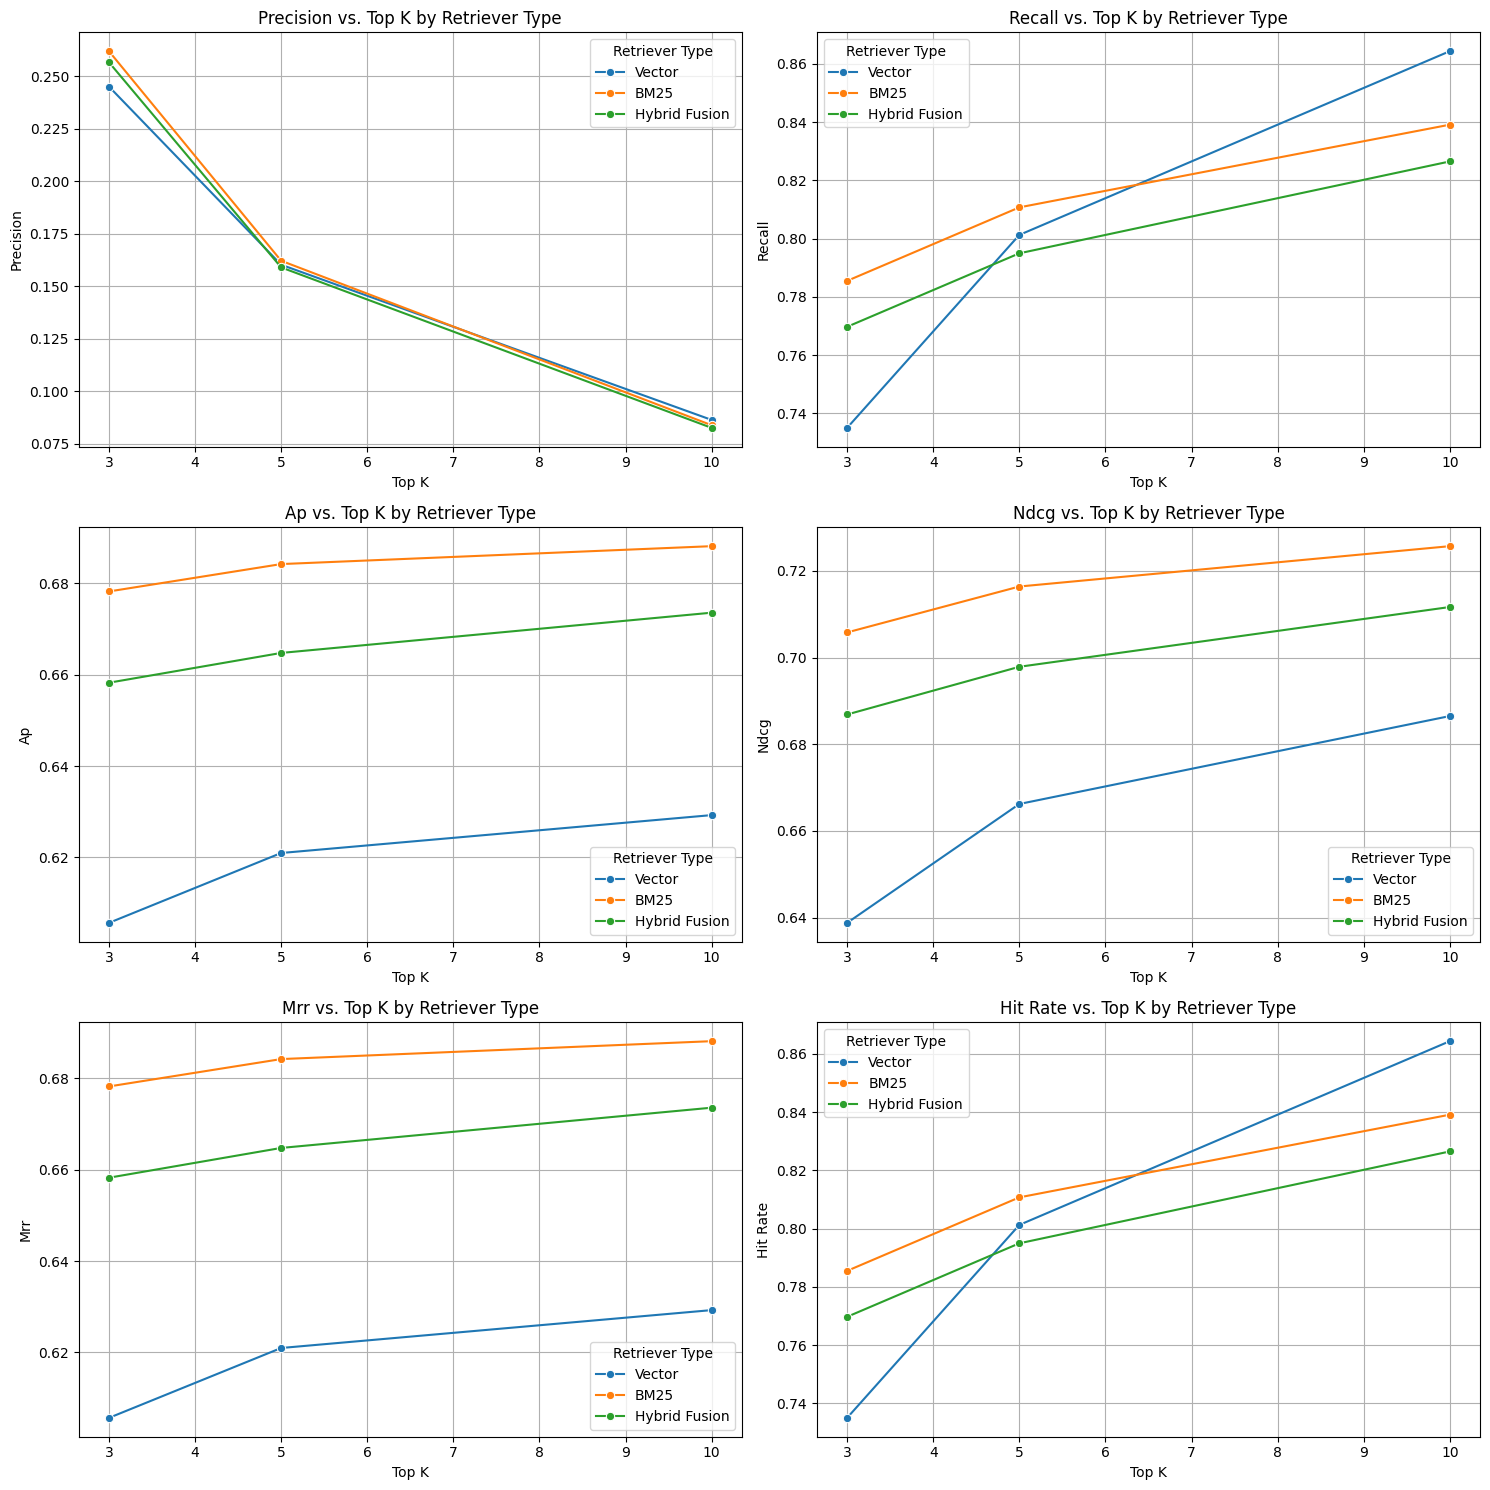

In [8]:
# --- Basic Plotting Example (optional) ---
if not retriever_summary_results.empty:
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Define the metrics to plot
    metrics_to_plot = ['avg_precision', 'avg_recall', 'avg_ap', 'avg_ndcg', 'avg_mrr', 'avg_hit_rate']
    
    # Determine grid size (e.g., 3 rows, 2 columns)
    n_metrics = len(metrics_to_plot)
    n_cols = 2
    n_rows = (n_metrics + n_cols - 1) // n_cols # Calculate rows needed

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False) # Ensure axes is always 2D array
    axes = axes.flatten() # Flatten the axes array for easy iteration

    # Plot each metric in a subplot
    for i, metric in enumerate(metrics_to_plot):
        if metric in retriever_summary_results.columns:
            ax = axes[i]
            sns.lineplot(data=retriever_summary_results, x='top_k', y=metric, hue='retriever_type', marker='o', ax=ax)
            # Improve title formatting
            metric_title = metric.replace('avg_', '').replace('_', ' ').title()
            ax.set_title(f'{metric_title} vs. Top K by Retriever Type')
            ax.set_xlabel('Top K')
            ax.set_ylabel(metric_title)
            ax.grid(True)
            # Place legend outside the plot for clarity if needed, or let seaborn handle it
            # ax.legend(title='Retriever Type', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.legend(title='Retriever Type')
        else:
            logger.warning(f"Metric '{metric}' not found in results, skipping plot.")
            axes[i].set_visible(False) # Hide subplot if metric is missing

    # Hide any unused subplots if the number of metrics is not a multiple of n_cols
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    # Adjust layout to prevent overlapping titles/labels
    plt.tight_layout()
    plt.show()

# Remove the old separate plots
#    # Plot Avg MRR vs Top K for different types
#    plt.figure(figsize=(10, 6))
#    sns.lineplot(data=retriever_summary_results, x='top_k', y='avg_mrr', hue='retriever_type', marker='o')
#    plt.title('Average MRR vs. Top K by Retriever Type')
#    plt.xlabel('Top K')
#    plt.ylabel('Average MRR')
#    plt.grid(True)
#    plt.show()
#
#    # Plot Avg Hit Rate vs Top K
#    plt.figure(figsize=(10, 6))
#    sns.lineplot(data=retriever_summary_results, x='top_k', y='avg_hit_rate', hue='retriever_type', marker='o')
#    plt.title('Average Hit Rate vs. Top K by Retriever Type')
#    plt.xlabel('Top K')
#    plt.ylabel('Average Hit Rate')
#    plt.grid(True)
#    plt.show()

## 5. Experiment 2: Response Quality (LLM Parameters/Models)

Evaluate faithfulness and relevance for responses generated using different LLM settings. This uses the previously generated QA dataset as input queries.

2025-04-18 18:03:32,218 - __main__ - INFO - Starting Experiment 2: Response Quality Comparison
2025-04-18 18:03:32,222 - __main__ - INFO - Loaded 317 queries from QA dataset for response evaluation.
2025-04-18 18:03:32,222 - __main__ - WARNING - Randomly selected 5 queries for faster response evaluation.
2025-04-18 18:03:32,222 - src.retrieval.retrieval - INFO - RetrieverFactory initialized.
2025-04-18 18:03:32,223 - src.evaluation.beir_evaluator - INFO - BeirEvaluatorWrapper initialized (without IndexManager dependency).
2025-04-18 18:03:32,223 - src.evaluation.question_generator - INFO - QuestionGenerator initialized.
2025-04-18 18:03:32,223 - __main__ - INFO - Using Judge LLM for response quality: openai/gpt-3.5-turbo
2025-04-18 18:03:32,223 - src.evaluation.judge_llm_provider - INFO - Attempting to get judge LLM: Provider='openai', Model='gpt-3.5-turbo'
2025-04-18 18:03:32,224 - src.evaluation.judge_llm_provider - INFO - Successfully initialized judge LLM: gpt-3.5-turbo
2025-04-18 

query after enhancement **Enhanced Query:**  
*"Can you explain the legal and operational significance of the 'APPLICABLE LAW' provision within the Plan? Specifically, how does this clause influence decision-making, enforceability, and potential disputes related to actions taken under the Plan?"*  

**Improvements:**  
1. **Grammar/Clarity:** Corrected "APPLICABLE" to "APPLICABLE" and restructured for conciseness.  
2. **Specificity:** Explicitly asks about *legal* and *operational* impacts, including enforceability and disputes.  
3. **Financial Context:** References "decision-making" to align with corporate governance/plan administration.  
4. **Structure:** Direct question format with clear sub-questions.  

**Optional Additions (if more context is known):**  
- *"Does this provision align with jurisdictional requirements for [specific financial action, e.g., mergers, bankruptcy]?"*  
- *"Are there examples of how this clause has affected litigation or regulatory compliance in simil

2025-04-18 18:04:00,005 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:04:09,409 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  
*"Can you explain the legal and operational significance of the 'APPLICABLE LAW' provision within the Plan? Specifically, how does this clause influence decision-making, enforceability, and potential disputes related to actions taken under the Plan?"*  

**Improvements:**  
1. **Grammar/Clarity:** Corrected "APPLICABLE" to "APPLICABLE" and restructured for conciseness.  
2. **Specificity:** Explicitly asks about *legal* and *operational* impacts, including enforceability and disputes.  
3. **Financial Context:** References "decision-making" to align with corporate governance/plan administration.  
4. **Structure:** Direct question format with clear sub-questions.  

**Optional Additions (if more context is known):**  
- *"Does this provision align with juri

query after enhancement **Enhanced Query:**  
*"What specific actions should an NVIDIA employee follow to report a potential violation of the company’s Compensation Recovery Policy (Clawback Policy), and what are the key compliance protocols involved?"*  

**Improvements:**  
1. **Grammar/Clarity:** Replaced "steps" with "specific actions" for precision and removed passive phrasing ("they are aware of").  
2. **Specificity:** Explicitly mentioned "report" to align with compliance procedures and included "(Clawback Policy)" for financial context.  
3. **Structure:** Framed as a direct question with two clear parts (actions + protocols).  
4. **Financial Context:** Added "compliance protocols" to emphasize regulatory/fiduciary implications.  

**Preserved Elements:**  
- Retained "NVIDIA" and "Compensation Recovery Policy" (core terms).  
- Maintained focus on employee responsibility and policy violations.


2025-04-18 18:04:45,923 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:04:54,140 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  
*"What specific actions should an NVIDIA employee follow to report a potential violation of the company’s Compensation Recovery Policy (Clawback Policy), and what are the key compliance protocols involved?"*  

**Improvements:**  
1. **Grammar/Clarity:** Replaced "steps" with "specific actions" for precision and removed passive phrasing ("they are aware of").  
2. **Specificity:** Explicitly mentioned "report" to align with compliance procedures and included "(Clawback Policy)" for financial context.  
3. **Structure:** Framed as a direct question with two clear parts (actions + protocols).  
4. **Financial Context:** Added "compliance protocols" to emphasize regulatory/fiduciary implications.  

**Preserved Elements:**  
- Retained "NVIDIA" and "Compensati

query after enhancement **Enhanced query:**  
*"Under what conditions can a Participant adjust their enrollment in the Plan (e.g., contribution changes, opt-out), and what circumstances would lead to the termination of their participation (e.g., employment termination, plan discontinuation)? Clarify any deadlines, eligibility requirements, or regulatory constraints that apply."*  

### Key Improvements:  
1. **Grammar/Clarity:** Restructured for conciseness and directness.  
2. **Specificity:** Added examples (e.g., "contribution changes," "employment termination") to clarify scope.  
3. **Financial Context:** Explicitly mentions regulatory constraints and deadlines, which are critical in plan management.  
4. **Structure:** Phrased as an actionable request for policy details (avoids double questions).  
5. **Preservation:** Retains "Participant" and "Plan" as formal terms without altering intent.  

### Optional Addition for Regulatory Context:  
If the Plan is governed by specific fr

2025-04-18 18:05:43,659 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:05:44,191 - src.querying.query_preprocessor - WARNING - LLM response was not valid JSON: . Falling back to basic heuristics.
2025-04-18 18:05:48,302 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced query:**  
*"Under what conditions can a Participant adjust their enrollment in the Plan (e.g., contribution changes, opt-out), and what circumstances would lead to the termination of their participation (e.g., employment termination, plan discontinuation)? Clarify any deadlines, eligibility requirements, or regulatory constraints that apply."*  

### Key Improvements:  
1. **Grammar/Clarity:** Restructured for conciseness and directness.  
2. **Specificity:** Added examples (e.g., "contribution changes," "employment termination") to clarify scope.  
3. **Financial Context:** Explicitly mentions regulatory constraints and deadlines

query after enhancement **Enhanced Query:**  
*"What was Meta Platforms, Inc.'s (NASDAQ: META) net income for the twelve-month period ending December 31, 2024, as reported in its audited financial statements?"*  

**Improvements:**  
1. **Grammar/Clarity** – Removed redundant "for" and restructured for conciseness.  
2. **Specificity** – Added stock ticker (NASDAQ: META) and clarified the source ("audited financial statements").  
3. **Terminology** – Maintained "net income" (GAAP term) and formalized "twelve-month period ending" to align with financial reporting conventions.  
4. **Context** – Explicitly tied the query to audited results, ensuring reliability expectations are clear.  

**Optional Additions (if user seeks forward-looking data):**  
*For projected results: "What is Meta Platforms, Inc.'s (META) consensus analyst estimate for net income in fiscal year 2024?"*  

This version maintains intent while enhancing precision and professionalism.


2025-04-18 18:06:46,244 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:06:46,858 - src.querying.query_preprocessor - WARNING - LLM response was not valid JSON: . Falling back to basic heuristics.
2025-04-18 18:06:50,862 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  
*"What was Meta Platforms, Inc.'s (NASDAQ: META) net income for the twelve-month period ending December 31, 2024, as reported in its audited financial statements?"*  

**Improvements:**  
1. **Grammar/Clarity** – Removed redundant "for" and restructured for conciseness.  
2. **Specificity** – Added stock ticker (NASDAQ: META) and clarified the source ("audited financial statements").  
3. **Terminology** – Maintained "net income" (GAAP term) and formalized "twelve-month period ending" to align with financial reporting conventions.  
4. **Context** – Explicitly tied the query to audited results, ensuring reliability expec

query after enhancement **Enhanced Query:**  
*"Can you detail the company's strategies for safeguarding its intellectual property (IP) rights—such as patents, trademarks, trade secrets, and licensing agreements—across domestic and international markets? Please include any financial investments, legal frameworks, or risk mitigation measures related to IP protection."*  

### Key Improvements:  
1. **Grammar/Clarity**: Simplified phrasing (e.g., "How does" → "Can you detail") and removed redundancy.  
2. **Specificity**: Explicitly requests financial/legal context (investments, frameworks) to align with financial analysis needs.  
3. **Structure**: Direct question format with clear scope (domestic + international).  
4. **Preserved Terms**: Kept key financial/legal terms (patents, trademarks, licensing) and broadened to "strategies" for analytical depth.  

This version maintains the original intent while making it more actionable for financial or investor-focused research.


2025-04-18 18:07:25,255 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:07:28,328 - src.querying.query_preprocessor - WARNING - LLM response was not valid JSON: . Falling back to basic heuristics.
2025-04-18 18:07:28,382 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  
*"Can you detail the company's strategies for safeguarding its intellectual property (IP) rights—such as patents, trademarks, trade secrets, and licensing agreements—across domestic and international markets? Please include any financial investments, legal frameworks, or risk mitigation measures related to IP protection."*  

### Key Improvements:  
1. **Grammar/Clarity**: Simplified phrasing (e.g., "How does" → "Can you detail") and removed redundancy.  
2. **Specificity**: Explicitly requests financial/legal context (investments, frameworks) to align with financial analysis needs.  
3. **Structure**: Direct question fo

query after enhancement Here’s the improved query with clarity, specificity, and grammatical correctness while preserving the original intent and financial context:  

**Enhanced Query:**  
*"Can you explain the legal and operational significance of the 'APPLICABLE LAW' provision in the Plan? Specifically, how does this clause influence decision-making, compliance requirements, and enforcement of actions taken under the Plan?"*  

### Key Improvements:  
1. **Grammar & Clarity** – Removed awkward phrasing ("what is the significance") and replaced it with a clear action ("explain").  
2. **Specificity** – Detailed the scope by asking about *legal and operational* significance, and explicitly mentioned *decision-making, compliance, and enforcement*.  
3. **Financial Context** – Maintained "Plan" as a formal document (capitalized), commonly seen in financial/legal agreements.  
4. **Structured as a Direct Question** – Framed as a clear request for information.  

This version ensures the 

2025-04-18 18:08:15,434 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:08:15,876 - src.querying.query_preprocessor - WARNING - LLM response was not valid JSON: . Falling back to basic heuristics.
2025-04-18 18:08:21,142 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: 'Here’s the improved query with clarity, specificity, and grammatical correctness while preserving the original intent and financial context:  

**Enhanced Query:**  
*"Can you explain the legal and operational significance of the 'APPLICABLE LAW' provision in the Plan? Specifically, how does this clause influence decision-making, compliance requirements, and enforcement of actions taken under the Plan?"*  

### Key Improvements:  
1. **Grammar & Clarity** – Removed awkward phrasing ("what is the significance") and replaced it with a clear action ("explain").  
2. **Specificity** – Detailed the scope by asking about *legal and operational* sig

query after enhancement Here’s the enhanced version of your query, incorporating your instructions while preserving the core intent:  

**Enhanced Query:**  
*"What specific procedures should an NVIDIA employee follow if they become aware of a potential violation of the company’s Compensation Recovery Policy (Clawback Policy), and what are the relevant reporting channels or compliance measures in place?"*  

### Key Improvements:  
1. **Grammar & Clarity** – Removed ambiguity by specifying "NVIDIA employee" and "procedures" instead of "steps."  
2. **Specificity** – Explicitly mentions the **Compensation Recovery Policy (Clawback Policy)**, reinforcing financial/regulatory relevance.  
3. **Structured as a Direct Question** – Clearly asks for procedures and reporting channels.  
4. **Added Financial Context** – References **compliance measures**, aligning with corporate governance expectations.  

This version ensures a precise, professional, and actionable query. Let me know if you'd 

2025-04-18 18:09:11,447 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:09:18,368 - src.querying.query_preprocessor - WARNING - LLM response was not valid JSON: . Falling back to basic heuristics.
2025-04-18 18:09:18,424 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: 'Here’s the enhanced version of your query, incorporating your instructions while preserving the core intent:  

**Enhanced Query:**  
*"What specific procedures should an NVIDIA employee follow if they become aware of a potential violation of the company’s Compensation Recovery Policy (Clawback Policy), and what are the relevant reporting channels or compliance measures in place?"*  

### Key Improvements:  
1. **Grammar & Clarity** – Removed ambiguity by specifying "NVIDIA employee" and "procedures" instead of "steps."  
2. **Specificity** – Explicitly mentions the **Compensation Recovery Policy (Clawback Policy)**, reinforcing financial/reg

query after enhancement  "What specific election change options are available to participants for modifying their 401(k) plan enrollment? Under what conditions can a participant's plan participation be involuntarily terminated?"

Analysis of improvements:
1. Changed "modifying their enrollment" to the more precise "election change options"
2. Specified "401(k) plan" to provide financial context
3. Distinguished between voluntary changes ("election change options") and involuntary actions ("terminated")
4. Simplified "under what circumstances" to "under what conditions"
5. Added "involuntarily" to clarify termination types
6. Structured as two clear, specific questions joined by logical progression
7. Maintained all financial terminology
8. Improved professional tone appropriate for retirement plan documentation

The enhanced version maintains the original intent while being more precise and actionable for plan administrators or HR professionals.


2025-04-18 18:10:12,583 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:10:18,536 - src.querying.query_preprocessor - WARNING - LLM response was not valid JSON: . Falling back to basic heuristics.
2025-04-18 18:10:18,586 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: ' "What specific election change options are available to participants for modifying their 401(k) plan enrollment? Under what conditions can a participant's plan participation be involuntarily terminated?"

Analysis of improvements:
1. Changed "modifying their enrollment" to the more precise "election change options"
2. Specified "401(k) plan" to provide financial context
3. Distinguished between voluntary changes ("election change options") and involuntary actions ("terminated")
4. Simplified "under what circumstances" to "under what conditions"
5. Added "involuntarily" to clarify termination types
6. Structured as two clear, specific questio

query after enhancement Here’s the enhanced query:  

**"What was Meta Platforms, Inc.'s (META) net income for the twelve-month period ending December 31, 2024, as reported in their annual financial statements?"**  

### Key Improvements:  
1. **Grammar & Clarity:**  
   - Corrected possessive form ("Meta Platforms, Inc.'s") and added the ticker symbol (META) for specificity.  
   - Replaced "twelve months ended" with "twelve-month period ending" for smoother phrasing.  

2. **Financial Context:**  
   - Added "as reported in their annual financial statements" to clarify the source of the data (e.g., 10-K filing).  
   - Explicitly requesting "net income" aligns with standard financial reporting terminology.  

3. **Precision:**  
   - The query now explicitly ties the request to Meta's official filings, reducing ambiguity.  

Would you like additional refinements, such as specifying GAAP vs. non-GAAP metrics or requesting comparative data (e.g., year-over-year trends)?


2025-04-18 18:10:48,762 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:11:02,288 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: 'Here’s the enhanced query:  

**"What was Meta Platforms, Inc.'s (META) net income for the twelve-month period ending December 31, 2024, as reported in their annual financial statements?"**  

### Key Improvements:  
1. **Grammar & Clarity:**  
   - Corrected possessive form ("Meta Platforms, Inc.'s") and added the ticker symbol (META) for specificity.  
   - Replaced "twelve months ended" with "twelve-month period ending" for smoother phrasing.  

2. **Financial Context:**  
   - Added "as reported in their annual financial statements" to clarify the source of the data (e.g., 10-K filing).  
   - Explicitly requesting "net income" aligns with standard financial reporting terminology.  

3. **Precision:**  
   - The query now explicitly ties the request to Meta's official filing

query after enhancement **Enhanced Query:**  
*"Can you provide a detailed overview of the company's strategies for safeguarding its intellectual property (IP) rights—including patents, trademarks, trade secrets, and licensing agreements—across domestic and international jurisdictions? Please highlight any financial or legal frameworks in place to mitigate risks and enforce protections."*  

### Key Improvements:  
1. **Grammar/Clarity**: Streamlined phrasing (e.g., "How does the company protect" → "Can you provide a detailed overview").  
2. **Specificity**: Explicitly requests "strategies" and mentions "financial/legal frameworks."  
3. **Structure**: Direct question format with clear scope (domestic/international).  
4. **Financial Context**: Added emphasis on risk mitigation (relevant to investors/analysts).  
5. **Formal Tone**: Maintains professionalism while avoiding jargon overload.


2025-04-18 18:11:58,613 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:12:11,751 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  
*"Can you provide a detailed overview of the company's strategies for safeguarding its intellectual property (IP) rights—including patents, trademarks, trade secrets, and licensing agreements—across domestic and international jurisdictions? Please highlight any financial or legal frameworks in place to mitigate risks and enforce protections."*  

### Key Improvements:  
1. **Grammar/Clarity**: Streamlined phrasing (e.g., "How does the company protect" → "Can you provide a detailed overview").  
2. **Specificity**: Explicitly requests "strategies" and mentions "financial/legal frameworks."  
3. **Structure**: Direct question format with clear scope (domestic/international).  
4. **Financial Context**: Added emphasis on risk mitigation (relevant to investors/

query after enhancement Here’s your enhanced query with improved clarity, specificity, and grammatical correctness while preserving the core intent and financial context:  

**"What is the purpose and legal significance of the 'APPLICABLE LAW' provision in this Plan? How does it influence decision-making, dispute resolution, or enforcement actions under the Plan?"**  

### Key Improvements:  
1. **Grammar & Structure** – Fixed phrasing for conciseness.  
2. **Clarity & Specificity** – Explicitly mentions *decision-making, dispute resolution, or enforcement actions* to provide financial/legal context.  
3. **Preservation** – Keeps "APPLICABLE LAW" in quotes and retains the formal tone.  
4. **Clear Request** – Structured as a direct question with logical flow.  

This version aligns with financial/legal inquiries while prompting a more detailed response. Let me know if further refinement is needed!


2025-04-18 18:13:10,543 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:13:20,989 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: 'Here’s your enhanced query with improved clarity, specificity, and grammatical correctness while preserving the core intent and financial context:  

**"What is the purpose and legal significance of the 'APPLICABLE LAW' provision in this Plan? How does it influence decision-making, dispute resolution, or enforcement actions under the Plan?"**  

### Key Improvements:  
1. **Grammar & Structure** – Fixed phrasing for conciseness.  
2. **Clarity & Specificity** – Explicitly mentions *decision-making, dispute resolution, or enforcement actions* to provide financial/legal context.  
3. **Preservation** – Keeps "APPLICABLE LAW" in quotes and retains the formal tone.  
4. **Clear Request** – Structured as a direct question with logical flow.  

This version aligns with financial/legal

query after enhancement **Enhanced Query:**  
*"What specific actions should an NVIDIA employee follow if they suspect or witness a potential violation of the company’s Compensation Recovery Policy (Clawback Policy), and what are the reporting channels or compliance protocols in such cases?"*  

**Improvements Made:**  
1. **Grammar/Clarity:** Replaced "are aware of a situation" with "suspect or witness" for precision.  
2. **Specificity:** Explicitly mentioned "Clawback Policy" (common financial term) and added "reporting channels/compliance protocols" to guide actionable steps.  
3. **Financial Context:** Highlighted the policy’s financial nature (clawbacks are critical in executive compensation).  
4. **Structure:** Framed as a direct question with clear intent.  

**Preserved Elements:**  
- Retained "NVIDIA" and "Compensation Recovery Policy" (core terms).  
- Maintained focus on employee procedures (original intent).  

**Optional Add-On (if deeper context is needed):**  
*"Does 

2025-04-18 18:13:54,929 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:14:07,798 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  
*"What specific actions should an NVIDIA employee follow if they suspect or witness a potential violation of the company’s Compensation Recovery Policy (Clawback Policy), and what are the reporting channels or compliance protocols in such cases?"*  

**Improvements Made:**  
1. **Grammar/Clarity:** Replaced "are aware of a situation" with "suspect or witness" for precision.  
2. **Specificity:** Explicitly mentioned "Clawback Policy" (common financial term) and added "reporting channels/compliance protocols" to guide actionable steps.  
3. **Financial Context:** Highlighted the policy’s financial nature (clawbacks are critical in executive compensation).  
4. **Structure:** Framed as a direct question with clear intent.  

**Preserved Elements:**  
- Retain

query after enhancement **Enhanced Query:**  

*"What are the available options for a Participant to modify their enrollment in the Plan, and under what specific conditions can their participation be terminated? Please include any relevant financial implications, deadlines, or restrictions that may apply."*  

### **Improvements Made:**  
1. **Grammar & Clarity:**  
   - Replaced "does a Participant have" with "are the available options" for smoother phrasing.  
   - Changed "under what circumstances" to "under what specific conditions" for precision.  

2. **Specificity & Financial Context:**  
   - Added a request for details on financial implications, deadlines, or restrictions to ensure a comprehensive response.  

3. **Structured as a Clear Request:**  
   - The revised query is direct, professional, and structured to elicit a detailed, actionable answer.  

4. **Preserved Core Intent & Terminology:**  
   - Kept key terms like *"Participant," "Plan,"* and *"terminated"* while imp

2025-04-18 18:14:48,250 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:15:02,530 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  

*"What are the available options for a Participant to modify their enrollment in the Plan, and under what specific conditions can their participation be terminated? Please include any relevant financial implications, deadlines, or restrictions that may apply."*  

### **Improvements Made:**  
1. **Grammar & Clarity:**  
   - Replaced "does a Participant have" with "are the available options" for smoother phrasing.  
   - Changed "under what circumstances" to "under what specific conditions" for precision.  

2. **Specificity & Financial Context:**  
   - Added a request for details on financial implications, deadlines, or restrictions to ensure a comprehensive response.  

3. **Structured as a Clear Request:**  
   - The revised query is direct, profession

query after enhancement Here’s the enhanced version of your query with improved clarity, specificity, and grammatical correctness while preserving the core intent:  

**Enhanced Query:**  
*"What was Meta Platforms, Inc.'s (NASDAQ: META) net income for the twelve-month period ending December 31, 2024, as reported in its annual financial statements?"*  

### Key Improvements:  
1. **Grammar & Clarity:**  
   - Corrected phrasing ("for the twelve months ended" → "for the twelve-month period ending").  
   - Added the parenthetical NASDAQ ticker symbol (META) for precision.  

2. **Specificity & Context:**  
   - Specified "as reported in its annual financial statements" to clarify the source of the data.  
   - Structured as a direct, professional request.  

3. **Preserved Financial Terms:**  
   - Kept "net income" (a standard financial metric) and the full company name.  

This version ensures the query is unambiguous, technically accurate, and aligned with financial reporting convent

2025-04-18 18:15:38,278 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:15:53,267 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: 'Here’s the enhanced version of your query with improved clarity, specificity, and grammatical correctness while preserving the core intent:  

**Enhanced Query:**  
*"What was Meta Platforms, Inc.'s (NASDAQ: META) net income for the twelve-month period ending December 31, 2024, as reported in its annual financial statements?"*  

### Key Improvements:  
1. **Grammar & Clarity:**  
   - Corrected phrasing ("for the twelve months ended" → "for the twelve-month period ending").  
   - Added the parenthetical NASDAQ ticker symbol (META) for precision.  

2. **Specificity & Context:**  
   - Specified "as reported in its annual financial statements" to clarify the source of the data.  
   - Structured as a direct, professional request.  

3. **Preserved Financial Terms:**  
   - Kept

query after enhancement **Enhanced Query:**  

*"Can you detail the company's strategies for safeguarding its intellectual property (IP) rights—including patents, trademarks, trade secrets, and licensing agreements—across domestic and international markets? Please include any financial implications, such as legal costs, revenue from licensing, or risks to valuation due to IP disputes."*  

### Key Improvements:  
1. **Grammar & Clarity**: Simplified phrasing while maintaining precision (e.g., "protect" → "safeguarding," added em-dashes for readability).  
2. **Specificity**: Explicitly requests financial context (legal costs, licensing revenue, valuation risks) to align with the user's likely intent as a financial query.  
3. **Structure**: Framed as a direct question with a logical flow (general strategy → financial impact).  
4. **Preserved Terms**: Kept all key terms (patents, trademarks, etc.) and added "valuation" to emphasize financial relevance.  

This version ensures the query

2025-04-18 18:16:28,677 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:16:43,556 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  

*"Can you detail the company's strategies for safeguarding its intellectual property (IP) rights—including patents, trademarks, trade secrets, and licensing agreements—across domestic and international markets? Please include any financial implications, such as legal costs, revenue from licensing, or risks to valuation due to IP disputes."*  

### Key Improvements:  
1. **Grammar & Clarity**: Simplified phrasing while maintaining precision (e.g., "protect" → "safeguarding," added em-dashes for readability).  
2. **Specificity**: Explicitly requests financial context (legal costs, licensing revenue, valuation risks) to align with the user's likely intent as a financial query.  
3. **Structure**: Framed as a direct question with a logical flow (general strat

query after enhancement **Enhanced Query:**  
*"Can you explain the legal and operational significance of the 'APPLICABLE LAW' provision in the Plan? Specifically, how does this clause influence decision-making, enforcement, and potential disputes under the Plan's framework?"*  

### Key Improvements:  
1. **Grammar/Clarity**: Removed awkward phrasing ("impact the actions taken") and replaced with precise terms ("influence decision-making, enforcement, and disputes").  
2. **Specificity**: Explicitly mentions "legal and operational significance" to clarify the scope of the answer.  
3. **Structure**: Framed as a direct request for explanation, with sub-questions to guide a detailed response.  
4. **Financial Context**: Implicitly highlights governance and compliance implications (relevant to financial/legal plans).  

### Optional Additions (if deeper context is needed):  
- *"Does the 'APPLICABLE LAW' provision affect jurisdictional risks for cross-border plans?"*  
- *"How might this

2025-04-18 18:17:22,610 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:17:41,203 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  
*"Can you explain the legal and operational significance of the 'APPLICABLE LAW' provision in the Plan? Specifically, how does this clause influence decision-making, enforcement, and potential disputes under the Plan's framework?"*  

### Key Improvements:  
1. **Grammar/Clarity**: Removed awkward phrasing ("impact the actions taken") and replaced with precise terms ("influence decision-making, enforcement, and disputes").  
2. **Specificity**: Explicitly mentions "legal and operational significance" to clarify the scope of the answer.  
3. **Structure**: Framed as a direct request for explanation, with sub-questions to guide a detailed response.  
4. **Financial Context**: Implicitly highlights governance and compliance implications (relevant to financial/

query after enhancement **Enhanced Query:**  
*"What specific actions should an NVIDIA employee follow to report a potential violation of the company’s Compensation Recovery Policy (Clawback Policy), and what are the key compliance protocols involved?"*  

### Key Improvements:  
1. **Grammar/Clarity**: Removed vague phrasing ("situation that may violate") and replaced with "potential violation."  
2. **Specificity**: Explicitly mentions "reporting" (action-oriented) and references the policy’s common name ("Clawback Policy").  
3. **Financial Context**: Highlights "compliance protocols" to align with governance standards.  
4. **Structure**: Directly addresses the employee’s need for procedural clarity.  

### Optional Additions (if space allows):  
- *"Does NVIDIA’s policy align with SEC Rule 10D-1 on clawbacks?"* (adds regulatory context).  
- *"Are there protections for whistleblowers under this policy?"* (encourages transparency).  

Maintains NVIDIA’s name and financial terminolo

2025-04-18 18:18:17,180 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:18:30,255 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  
*"What specific actions should an NVIDIA employee follow to report a potential violation of the company’s Compensation Recovery Policy (Clawback Policy), and what are the key compliance protocols involved?"*  

### Key Improvements:  
1. **Grammar/Clarity**: Removed vague phrasing ("situation that may violate") and replaced with "potential violation."  
2. **Specificity**: Explicitly mentions "reporting" (action-oriented) and references the policy’s common name ("Clawback Policy").  
3. **Financial Context**: Highlights "compliance protocols" to align with governance standards.  
4. **Structure**: Directly addresses the employee’s need for procedural clarity.  

### Optional Additions (if space allows):  
- *"Does NVIDIA’s policy align with SEC Rule 10D-1 o

query after enhancement **Enhanced Query:**  

*"What are the available options for a Participant to modify their enrollment in the Plan, and under what specific conditions can their participation be terminated? Please include any relevant financial or administrative policies that govern these changes."*  

### **Improvements Made:**  
1. **Grammar & Clarity:**  
   - Removed redundant phrasing ("Question:") and made it a direct inquiry.  
   - Changed "does a Participant have" to "are the available options" for smoother readability.  

2. **Specificity & Structure:**  
   - Added *"Please include any relevant financial or administrative policies"* to encourage a more detailed response.  
   - Clarified *"specific conditions"* instead of just *"circumstances"* for precision.  

3. **Preserved Financial Terms:**  
   - Kept *"Participant"* and *"Plan"* (assuming these are formal terms from the plan documents).  

4. **Structured as a Clear Request:**  
   - Phrased as a direct question 

2025-04-18 18:19:11,935 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:19:24,677 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  

*"What are the available options for a Participant to modify their enrollment in the Plan, and under what specific conditions can their participation be terminated? Please include any relevant financial or administrative policies that govern these changes."*  

### **Improvements Made:**  
1. **Grammar & Clarity:**  
   - Removed redundant phrasing ("Question:") and made it a direct inquiry.  
   - Changed "does a Participant have" to "are the available options" for smoother readability.  

2. **Specificity & Structure:**  
   - Added *"Please include any relevant financial or administrative policies"* to encourage a more detailed response.  
   - Clarified *"specific conditions"* instead of just *"circumstances"* for precision.  

3. **Preserved Financial

query after enhancement Here’s the enhanced version of your query, incorporating your instructions while preserving the core intent:  

**Enhanced Query:**  
*"What was Meta Platforms, Inc. (META) reported net income for the twelve-month period ending December 31, 2024? Please provide the figure in USD, along with any relevant context such as year-over-year growth or key drivers of performance."*  

### Key Improvements:  
1. **Grammar & Clarity** – Removed redundancy ("for the twelve months ended") and streamlined phrasing.  
2. **Specificity** – Added the stock ticker (META) and requested the currency (USD).  
3. **Financial Context** – Included optional context (YoY growth, performance drivers) to enhance usefulness.  
4. **Structured Request** – Framed as a direct question with clear parameters.  

This version ensures precision while maintaining the original intent. Let me know if you'd like further refinements!


2025-04-18 18:19:59,859 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:20:14,237 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: 'Here’s the enhanced version of your query, incorporating your instructions while preserving the core intent:  

**Enhanced Query:**  
*"What was Meta Platforms, Inc. (META) reported net income for the twelve-month period ending December 31, 2024? Please provide the figure in USD, along with any relevant context such as year-over-year growth or key drivers of performance."*  

### Key Improvements:  
1. **Grammar & Clarity** – Removed redundancy ("for the twelve months ended") and streamlined phrasing.  
2. **Specificity** – Added the stock ticker (META) and requested the currency (USD).  
3. **Financial Context** – Included optional context (YoY growth, performance drivers) to enhance usefulness.  
4. **Structured Request** – Framed as a direct question with clear parameters.  


query after enhancement **Enhanced Query:**  

*"Can you provide a detailed overview of the company's strategies for safeguarding its intellectual property (IP) rights—including patents, trademarks, trade secrets, and licensing agreements—across domestic and international markets? Additionally, how do these protections contribute to the company's financial stability and competitive advantage?"*  

### **Improvements Made:**  
1. **Grammar & Clarity:**  
   - Rephrased for smoother readability while maintaining technical accuracy.  
   - Structured as a direct question for better engagement.  

2. **Specificity & Depth:**  
   - Explicitly mentions "strategies" to prompt a more structured response.  
   - Adds "competitive advantage" to tie IP protection to financial performance.  

3. **Financial Context:**  
   - Links IP protection to "financial stability," making it more relevant to investors and analysts.  

4. **Structure:**  
   - Separates core question from additional financial

2025-04-18 18:20:48,560 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:21:03,395 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  

*"Can you provide a detailed overview of the company's strategies for safeguarding its intellectual property (IP) rights—including patents, trademarks, trade secrets, and licensing agreements—across domestic and international markets? Additionally, how do these protections contribute to the company's financial stability and competitive advantage?"*  

### **Improvements Made:**  
1. **Grammar & Clarity:**  
   - Rephrased for smoother readability while maintaining technical accuracy.  
   - Structured as a direct question for better engagement.  

2. **Specificity & Depth:**  
   - Explicitly mentions "strategies" to prompt a more structured response.  
   - Adds "competitive advantage" to tie IP protection to financial performance.  

3. **Financial Conte

query after enhancement **Enhanced Query:**  

*"Can you explain the legal and operational significance of the 'APPLICABLE LAW' provision in the Plan? Specifically, how does this clause influence decision-making, enforceability, and potential disputes under the Plan's framework?"*  

### **Improvements Made:**  
1. **Grammar & Clarity:** Restructured for conciseness and directness.  
2. **Specificity:** Explicitly asks about *legal* and *operational* impacts (decision-making, enforceability, disputes).  
3. **Financial/Legal Context:** Reinforces that this is about governance within a structured *Plan* (likely a financial, corporate, or restructuring plan).  
4. **Structured as a Request:** Framed as a clear, professional inquiry.  

This version ensures the query is precise, legally relevant, and actionable for financial or legal experts. Let me know if further refinements are needed!


2025-04-18 18:21:40,315 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:21:55,061 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  

*"Can you explain the legal and operational significance of the 'APPLICABLE LAW' provision in the Plan? Specifically, how does this clause influence decision-making, enforceability, and potential disputes under the Plan's framework?"*  

### **Improvements Made:**  
1. **Grammar & Clarity:** Restructured for conciseness and directness.  
2. **Specificity:** Explicitly asks about *legal* and *operational* impacts (decision-making, enforceability, disputes).  
3. **Financial/Legal Context:** Reinforces that this is about governance within a structured *Plan* (likely a financial, corporate, or restructuring plan).  
4. **Structured as a Request:** Framed as a clear, professional inquiry.  

This version ensures the query is precise, legally relevant, and acti

query after enhancement Here’s an improved version of your query that adheres to the instructions while preserving the core intent and enhancing clarity, specificity, and professionalism:  

**Enhanced Query:**  
"What are the formal steps an NVIDIA employee should follow if they become aware of a potential violation of the company’s Compensation Recovery Policy (Clawback Policy), and what key financial or compliance considerations should they keep in mind?"  

### Key Improvements:  
1. **Grammar/Clarity**:  
   - Replaced "may violate" with "potential violation" for precision.  
   - Added "formal steps" to emphasize procedural correctness.  

2. **Specificity**:  
   - Explicitly mentioned "Clawback Policy" (a common financial term for compensation recovery) to align with industry jargon.  
   - Added "financial or compliance considerations" to highlight broader implications.  

3. **Financial Context**:  
   - Referenced compliance, which is critical in financial governance.  
   -

2025-04-18 18:22:50,935 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:22:59,583 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: 'Here’s an improved version of your query that adheres to the instructions while preserving the core intent and enhancing clarity, specificity, and professionalism:  

**Enhanced Query:**  
"What are the formal steps an NVIDIA employee should follow if they become aware of a potential violation of the company’s Compensation Recovery Policy (Clawback Policy), and what key financial or compliance considerations should they keep in mind?"  

### Key Improvements:  
1. **Grammar/Clarity**:  
   - Replaced "may violate" with "potential violation" for precision.  
   - Added "formal steps" to emphasize procedural correctness.  

2. **Specificity**:  
   - Explicitly mentioned "Clawback Policy" (a common financial term for compensation recovery) to align with industry jargon.  
   - Add

query after enhancement **Enhanced Query:**  
*"What are the available options for a Participant to amend their enrollment in the Plan? Additionally, under what specific conditions (e.g., employment termination, retirement, or breach of terms) can their participation in the Plan be terminated?"*  

### Key Improvements:  
1. **Grammar & Clarity**:  
   - Replaced "modifying" with "amend" (more precise financial/plan terminology).  
   - Split into two distinct questions for readability.  

2. **Specificity**:  
   - Added examples of termination conditions (employment status, breaches) to guide a targeted response.  
   - Explicitly referenced "Plan" (assuming it’s a formal retirement/benefits plan).  

3. **Structure**:  
   - Framed as a direct request with logical flow (enrollment → termination).  

4. **Financial Context**:  
   - Implied the Plan’s association with employment/retirement (common for 401(k), ESOPs, etc.) without altering original intent.  

**Note**: If "Plan" refer

2025-04-18 18:24:11,385 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:24:11,927 - src.querying.query_preprocessor - WARNING - LLM response was not valid JSON: . Falling back to basic heuristics.
2025-04-18 18:24:16,339 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: '**Enhanced Query:**  
*"What are the available options for a Participant to amend their enrollment in the Plan? Additionally, under what specific conditions (e.g., employment termination, retirement, or breach of terms) can their participation in the Plan be terminated?"*  

### Key Improvements:  
1. **Grammar & Clarity**:  
   - Replaced "modifying" with "amend" (more precise financial/plan terminology).  
   - Split into two distinct questions for readability.  

2. **Specificity**:  
   - Added examples of termination conditions (employment status, breaches) to guide a targeted response.  
   - Explicitly referenced "Plan" (assuming it’s 

query after enhancement Here’s the enhanced version of your query, following your instructions:  

**Enhanced Query:**  
*"What was Meta Platforms, Inc. (NASDAQ: META) reported net income for the full fiscal year ending December 31, 2024? Please provide the figure in millions (or billions) of U.S. dollars and specify whether it is GAAP or non-GAAP, if applicable."*  

### Key Improvements:  
1. **Clarity & Specificity:**  
   - Added the stock ticker **(NASDAQ: META)** for precision.  
   - Clarified **"full fiscal year ending"** instead of "twelve months ended."  

2. **Financial Context:**  
   - Explicitly requested the currency (U.S. dollars) and scale (millions/billions).  
   - Specified interest in GAAP vs. non-GAAP accounting standards, as Meta often reports both.  

3. **Grammar & Structure:**  
   - Made the question more concise and direct.  

This version ensures the query is professional, unambiguous, and aligned with financial reporting conventions. Let me know if you'd l

2025-04-18 18:24:49,871 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:24:58,260 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: 'Here’s the enhanced version of your query, following your instructions:  

**Enhanced Query:**  
*"What was Meta Platforms, Inc. (NASDAQ: META) reported net income for the full fiscal year ending December 31, 2024? Please provide the figure in millions (or billions) of U.S. dollars and specify whether it is GAAP or non-GAAP, if applicable."*  

### Key Improvements:  
1. **Clarity & Specificity:**  
   - Added the stock ticker **(NASDAQ: META)** for precision.  
   - Clarified **"full fiscal year ending"** instead of "twelve months ended."  

2. **Financial Context:**  
   - Explicitly requested the currency (U.S. dollars) and scale (millions/billions).  
   - Specified interest in GAAP vs. non-GAAP accounting standards, as Meta often reports both.  

3. **Grammar & Structure:**

query after enhancement Here’s an enhanced version of your query that improves clarity, specificity, and structure while preserving financial and legal terminology:  

**"Could you detail the company's strategies for safeguarding its intellectual property (IP) rights—such as patents, trademarks, trade secrets, and licensing agreements—across domestic and international markets? Please include any relevant financial impacts, legal frameworks, or risk mitigation measures related to IP protection."**  

### Key Improvements:  
1. **Grammatical Fixes** – Structured as a clear question with proper punctuation.  
2. **Clarity & Specificity** – Expanded to emphasize financial/legal impacts and risk management.  
3. **Terminology Preservation** – Retains key terms (patents, trademarks, trade secrets, licensing).  
4. **Structured Request** – Directly phrased as an actionable inquiry.  
5. **Financial Context Added** – Explicitly asks for financial implications (costs, revenue from licensing, le

2025-04-18 18:25:58,733 - src.querying.query_preprocessor - INFO - Performing basic intent analysis using spaCy.
2025-04-18 18:26:06,869 - src.querying.query_engine - INFO - Query preprocessed. Enhanced Query: 'Here’s an enhanced version of your query that improves clarity, specificity, and structure while preserving financial and legal terminology:  

**"Could you detail the company's strategies for safeguarding its intellectual property (IP) rights—such as patents, trademarks, trade secrets, and licensing agreements—across domestic and international markets? Please include any relevant financial impacts, legal frameworks, or risk mitigation measures related to IP protection."**  

### Key Improvements:  
1. **Grammatical Fixes** – Structured as a clear question with proper punctuation.  
2. **Clarity & Specificity** – Expanded to emphasize financial/legal impacts and risk management.  
3. **Terminology Preservation** – Retains key terms (patents, trademarks, trade secrets, licensing)

,config_id,provider,model,temperature,top_p,avg_faithfulness,avg_relevancy,faithfulness_pass_rate,relevancy_pass_rate,num_errors,num_queries_evaluated
0,openai-gpt-3.5-turbo-T0.1-P0.9,openai,gpt-3.5-turbo,0.1,0.9,0.8,0.8,0.8,0.8,0,5
1,openai-gpt-3.5-turbo-T0.7-P0.9,openai,gpt-3.5-turbo,0.7,0.9,0.6,0.8,0.6,0.8,0,5
2,openai-gpt-4o-T0.1-P0.9,openai,gpt-4o,0.1,0.9,0.4,0.6,0.4,0.6,0,5
3,openai-gpt-4o-T0.7-P0.9,openai,gpt-4o,0.7,0.9,0.4,0.8,0.4,0.8,0,5


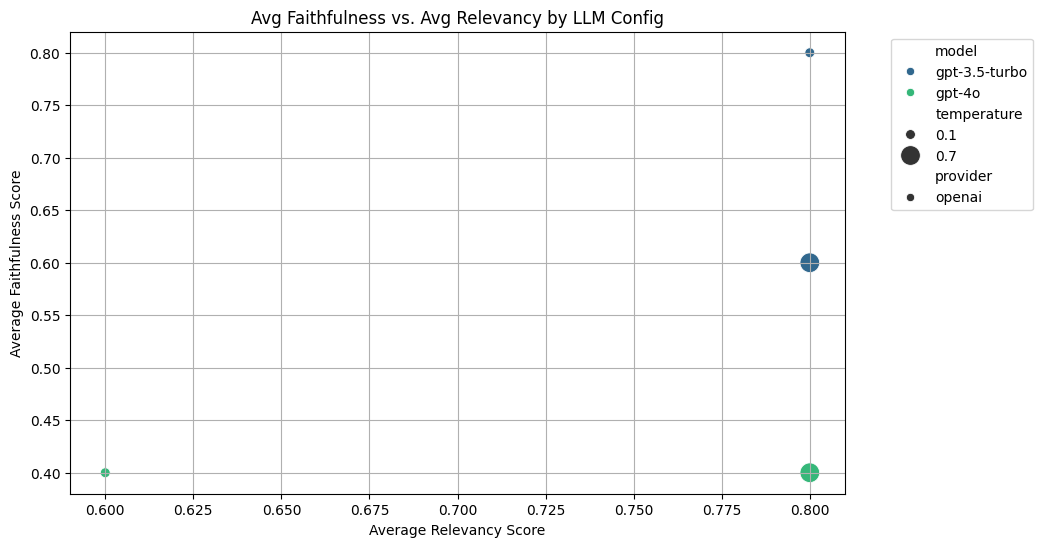

In [14]:
def run_response_quality_evaluation(index: VectorStoreIndex, qa_path: str, llm_configs: list, retriever_config: dict):
    """Runs response quality evaluations for given LLM configurations."""
    if not os.path.exists(qa_path):
        logger.error(f"QA dataset not found at {qa_path}. Cannot run response evaluation.")
        return pd.DataFrame()

    from llama_index.core.evaluation import EmbeddingQAFinetuneDataset
    try:
        qa_dataset = EmbeddingQAFinetuneDataset.from_json(qa_path)
        queries = list(qa_dataset.queries.values()) # Get list of query strings
        logger.info(f"Loaded {len(queries)} queries from QA dataset for response evaluation.")
        if not queries:
             logger.error("QA dataset contains no queries.")
             return pd.DataFrame()
        import random
        num_to_select = 5
        if len(queries) >= num_to_select:
            queries = random.sample(queries, num_to_select)
            logger.warning(f"Randomly selected {len(queries)} queries for faster response evaluation.")
        elif len(queries) > 0:
            # Use all available queries if fewer than num_to_select
            logger.warning(f"Using all {len(queries)} available queries (fewer than {num_to_select}) for response evaluation.")
         # No change needed if queries is already empty, the function handles it later.
    except Exception as e:
        logger.error(f"Failed to load queries from QA dataset {qa_path}: {e}", exc_info=True)
        return pd.DataFrame()

    all_results = []
    retriever_factory = RetrieverFactory(config_loader)
    evaluator = RAGEvaluator(config_loader, storage_manager) # Needed for evaluate_response_quality

    # --- Configure Judge LLM (Use a consistent one for all evaluations) ---
    eval_config = config_loader.get_evaluation_config()
    judge_config = eval_config.get('judge_llm_providers', {})
    judge_provider_name = 'openai' # Or get from config
    judge_model_name = judge_config.get(judge_provider_name, ['gpt-4-turbo'])[0] # Example: Use GPT-4 Turbo as judge
    logger.info(f"Using Judge LLM for response quality: {judge_provider_name}/{judge_model_name}")
    try:
        judge_llm = get_judge_llm(judge_provider_name, judge_model_name)
        if judge_llm is None:
            logger.error("Failed to initialize consistent Judge LLM. Aborting response evaluation.")
            return pd.DataFrame()
    except Exception as e:
        logger.error(f"Error initializing Judge LLM: {e}", exc_info=True)
        return pd.DataFrame()

    # --- Create the chosen retriever once ---
    logger.info(f"Using retriever config for all response evaluations: {retriever_config}")
    base_retriever = retriever_factory.create_retriever(
        index=index,
        retriever_type=retriever_config['type'],
        top_k=retriever_config['top_k']
    )
    if base_retriever is None:
        logger.error("Failed to create base retriever. Aborting response evaluation.")
        return pd.DataFrame()


    logger.info(f"Starting response quality evaluation for {len(llm_configs)} LLM configurations across {len(queries)} queries...")

    # --- Loop through LLM Configs ---
    for llm_idx, llm_config in enumerate(llm_configs):
        provider = llm_config['provider']
        model = llm_config['model']
        temp = llm_config['temperature']
        top_p = llm_config.get('top_p', 0.9) # Use default if not specified
        max_tokens = llm_config.get('max_tokens', 512) # Reasonable default
        config_id = f"{provider}-{model}-T{temp}-P{top_p}"
        logger.info(f"\n--- Evaluating LLM Config {llm_idx+1}/{len(llm_configs)}: {config_id} ---")

        config_query_results = []

        try:
            # 1. Initialize LLM for this config
            llm = get_llm_provider(
                provider_name=provider,
                model_name=model,
                temperature=temp,
                top_p=top_p,
                max_tokens=max_tokens
            )
            if llm is None:
                logger.error(f"Failed to get LLM for {config_id}. Skipping config.")
                continue

            # 2. Initialize Query Engine with this LLM and the base retriever
            # We need a QueryEngine instance that uses the specific LLM & Retriever
            # Adapt this based on your QueryEngine's __init__
            query_engine = QueryEngine(llm=llm, config_loader=config_loader) # Pass necessary args
            # Manually set the retriever for this instance if needed
            query_engine.retriever = base_retriever
            # Or if QueryEngine takes retriever config:
            # query_engine = QueryEngine(llm=llm, config_loader=config_loader, retriever_config=retriever_config)


            # 3. Loop through Queries
            for q_idx, query_text in enumerate(queries):
                logger.debug(f"Processing query {q_idx+1}/{len(queries)} for {config_id}: '{query_text[:50]}...'")
                try:
                    # 4. Generate Response and Get Context using QueryEngine
                    # We need process_query to return response AND context nodes
                    # Adapt if your process_query has different args or return structure
                    response_str, success, analysis, context_nodes = query_engine.process_query(
                        query=query_text,
                        index=index, # May not be needed if QE uses internal index/retriever
                        provider_name=provider,
                        model_name=model,
                        retriever_type=retriever_config['type'],
                        force_rag=True, # Force RAG to ensure context for faithfulness
                        prompt_type=None, # Added missing argument
                        top_k=retriever_config['top_k'],
                        persona=None # Added missing argument
                    )

                    if not success or not response_str:
                        logger.warning(f"Failed to get valid response for query {q_idx+1}. Skipping eval for this query.")
                        continue

                    # Extract context strings
                    context_texts = [node.get_content() for node in context_nodes] if context_nodes else []

                    # 5. Evaluate Faithfulness & Relevancy for this response
                    results_df, metrics = evaluator.evaluate_response_quality(
                        query=query_text,
                        response_str=response_str,
                        retrieved_contexts=context_texts,
                        judge_llm=judge_llm
                    )

                    if metrics:
                        # Add identifying info to the metrics dict
                        metrics['config_id'] = config_id
                        metrics['provider'] = provider
                        metrics['model'] = model
                        metrics['temperature'] = temp
                        metrics['top_p'] = top_p
                        metrics['query'] = query_text # Keep track of the query
                        # Add context and response if needed for detailed analysis
                        # metrics['context_used'] = context_texts
                        # metrics['generated_response'] = response_str
                        config_query_results.append(metrics)
                    else:
                         logger.warning(f"Response quality evaluation returned no metrics for query {q_idx+1}, config {config_id}.")

                except Exception as query_e:
                    logger.error(f"Error processing query {q_idx+1} for config {config_id}: {query_e}", exc_info=True)

            # --- Aggregate results for this LLM config ---
            if config_query_results:
                temp_df = pd.DataFrame(config_query_results)
                # Calculate average scores etc. for this config run
                avg_faithfulness = temp_df['faithfulness_score'].mean(skipna=True)
                avg_relevancy = temp_df['relevancy_score'].mean(skipna=True)
                pass_faith = (temp_df['is_faithful'] == True).mean(skipna=True)
                pass_rel = (temp_df['is_relevant'] == True).mean(skipna=True)
                errors = temp_df['error'].notna().sum()

                summary_metrics = {
                    'config_id': config_id,
                    'provider': provider,
                    'model': model,
                    'temperature': temp,
                    'top_p': top_p,
                    'avg_faithfulness': avg_faithfulness,
                    'avg_relevancy': avg_relevancy,
                    'faithfulness_pass_rate': pass_faith,
                    'relevancy_pass_rate': pass_rel,
                    'num_errors': errors,
                    'num_queries_evaluated': len(temp_df)
                }
                all_results.append(summary_metrics)
                logger.info(f"LLM Config {llm_idx+1} Summary: {summary_metrics}")
                # Optionally save detailed results per config
                # temp_df.to_csv(f"response_eval_details_{config_id}.csv")

        except Exception as config_e:
            logger.error(f"Error processing LLM config {config_id}: {config_e}", exc_info=True)

    logger.info("Response quality evaluation complete.")
    return pd.DataFrame(all_results)


# --- Define LLM Configurations ---
llm_configs_to_test = [
    # OpenAI
    {'provider': 'openai', 'model': 'gpt-3.5-turbo', 'temperature': 0.1, 'top_p': 0.9},
    {'provider': 'openai', 'model': 'gpt-3.5-turbo', 'temperature': 0.7, 'top_p': 0.9},
    {'provider': 'openai', 'model': 'gpt-o1-mini', 'temperature': 0.1, 'top_p': 0.9},
    {'provider': 'openai', 'model': 'gpt-o1-mini', 'temperature': 0.7, 'top_p': 0.9},
    {'provider': 'openai', 'model': 'gpt-4o', 'temperature': 0.1, 'top_p': 0.9},
    {'provider': 'openai', 'model': 'gpt-4o', 'temperature': 0.7, 'top_p': 0.9},

    # Add OpenRouter / HuggingFace models if configured and keys are set
    # Ensure API keys are set in your environment for these providers
    {'provider': 'openrouter', 'model': 'mistralai/mistral-7b-instruct', 'temperature': 0.3, 'top_p': 0.9},
    {'provider': 'openrouter', 'model': 'mistralai/mixtral-8x7b-instruct', 'temperature': 0.3, 'top_p': 0.9},
    {'provider': 'openrouter', 'model': 'google/gemini-pro', 'temperature': 0.5, 'top_p': 0.9},
    # Note: HuggingFace integration might require specific setup (e.g., Inference Endpoints or local TGI)
    {'provider': 'huggingface', 'model': 'deepseek/deepseek-chat', 'temperature': 0.2, 'top_p': 0.9},
]

# --- Define Retriever Config to Use (e.g., best from Exp 1 or a default) ---
response_retriever_config = {'type': 'bm25', 'top_k': 10}

# --- Run Experiment 2 ---
if qa_generation_successful and vector_index:
    logger.info("Starting Experiment 2: Response Quality Comparison")
    response_summary_results = run_response_quality_evaluation(
        vector_index,
        QA_DATASET_PATH,
        llm_configs_to_test,
        response_retriever_config
    )

    logger.info("Response Quality Evaluation Summary:")
    # Display DataFrame in Jupyter output
    from IPython.display import display
    display(response_summary_results)

    # --- Basic Plotting Example (optional) ---
    if not response_summary_results.empty:
        import matplotlib.pyplot as plt
        import seaborn as sns
        # Plot Faithfulness vs Relevancy
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=response_summary_results, x='avg_relevancy', y='avg_faithfulness', hue='model', size='temperature', style='provider', palette='viridis', sizes=(50, 200))
        plt.title('Avg Faithfulness vs. Avg Relevancy by LLM Config')
        plt.xlabel('Average Relevancy Score')
        plt.ylabel('Average Faithfulness Score')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()
else:
    logger.warning("Skipping Experiment 2 due to previous errors.")

## 6. Analysis and Conclusion

Analyze the results from the DataFrames (`retriever_summary_results`, `response_summary_results`) displayed above.

**Observations from Retriever Evaluation:**
*   How did `top_k` affect metrics like MRR and Hit Rate for each retriever type?
*   Which retriever type performed best overall for this dataset based on the chosen metrics?
*   Did BM25 or Hybrid offer significant advantages over simple Vector search?

**Observations from Response Quality Evaluation:**
*   Which LLM model generally produced more faithful responses? Which produced more relevant responses?
*   How did temperature and top_p affect faithfulness and relevance scores? Was there a trade-off?
*   Were there significant differences between providers (e.g., OpenAI vs. OpenRouter)?
*   Which configuration provided the best balance of faithfulness and relevance for your needs?

**Next Steps:**
*   Fine-tune the chosen retriever settings.
*   Select the optimal LLM model and parameters based on the desired balance of response quality metrics.
*   Consider adding more evaluation metrics (e.g., Answer Correctness, Latency).
*   Expand the QA dataset for more robust evaluation.